In [1]:
# AL FIN: https://www.tensorflow.org/install/pip?hl=es-419#windows-native
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
['/device:CPU:0', '/device:GPU:0']


In [2]:
import os
import sys
import inspect

# currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
# parentdir = os.path.dirname(currentdir)
# print(currentdir)
# sys.path.insert(0, parentdir) 
currentdir = os.path.dirname(os.path.abspath("."))
sys.path.insert(0, currentdir) 

from toynetwork import Network, Layer,Functions


In [3]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from util import networkfunctions as Functions
from util import mnistdataset as mnist
from pathlib import Path
import pandas as pd
#-------------------------
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

#from scipy.stats import pearsonr
#import seaborn as sns
# from scipy.stats import kde

# from tensorflow._api.v2.data import Dataset
import tensorflow as tf

keras=tf.keras

from keras.losses import Huber
from keras import Model, regularizers
from keras.models import load_model
from keras.utils import plot_model
from keras.layers import Flatten, Dense, Dropout, Input, concatenate, LeakyReLU, Convolution1D, MaxPooling1D, BatchNormalization, SpatialDropout1D,Convolution2D,SpatialDropout2D
from keras import backend as K
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from keras.optimizers import Adam
#-------------------------
# https://stackoverflow.com/questions/58956619/tensorflow-2-0-list-physical-devices-doesnt-detect-my-gpu

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


In [17]:


def architecture(nrows,ncols): # spc dim, imput data (10 params) 

    ipt       = Input(shape=(nrows,ncols,1))     #INPUT DIMENSION OF THE SPECTROSCOPIC CHANNEL
    ipt_all = [ipt]

    x = Convolution2D(16, (3,3), padding='valid', name = 'convol_1')(ipt)   #CONVOLUTION LAYER 1
    x = LeakyReLU()(x)
    x=MaxPooling2D(pool_size=(2,2))(x)
    x = SpatialDropout2D(0.2)(x)

    x = Convolution2D(32, (3,3), padding='valid', name = 'convol_2')(x)     #CONVOLUTION LAYER 2
    x = LeakyReLU()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = SpatialDropout2D(0.2)(x)

    x = Convolution2D(64, (3,3), padding='valid', name = 'convol_3')(x)     #CONVOLUTION LAYER 2
    x = LeakyReLU()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = SpatialDropout2D(0.2)(x)    
    
    x = Flatten()(x)
    x = Dense(128)(x)       #FULLY CONNECTED LAYER
    x = LeakyReLU()(x)
    x = Dropout(0.2)(x)    #DROPOUT LAYER

    x = Dense(64)(x)
    x = LeakyReLU()(x)

    # cnnout = Dense(y_train.shape[1], activation='linear')(x)  #OUTPUT LAYER
    cnnout = Dense(10, activation='softmax')(x)  #OUTPUT LAYER
    cnn = Model(ipt_all, cnnout)

    return cnn



In [8]:
# Load dataset
Y_T, X_T, nrows, ncols = mnist.load_data_augmented("../")
# X_T = X_T.T
Y_V, X_V, _, _ = mnist.load_test_data("../")
# X_V = X_V.T

path=Path.cwd()

### RESCALE LABELS FROM 0 TO 1
# scaler_y = preprocessing.MinMaxScaler()
# y_train  = scaler_y.fit_transform(Y_T.reshape(-1,1))[:limit,:]
y_train=Y_T
# y_test   = scaler_y.transform(Y_V.reshape(-1,1))
y_test=Y_V

### RESCALE PARAMS FROM 0 TO 1
scaler_x = preprocessing.MinMaxScaler()
# print(X_T.shape) #(60000, 784)
X_train   = scaler_x.fit_transform(X_T)
X_test    = scaler_x.transform(X_V)

In [18]:
v="CNN_16_32_64_FC_128_64_gpu_aug"
training=True
n_epoch_max=30
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


cnn = architecture(nrows, ncols)
cnn.summary()


cnn.compile(loss='sparse_categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])




if training:
    history = cnn.fit([X_train.reshape(-1,nrows,ncols)], y_train,
                    batch_size=16,
                    epochs=n_epoch_max,
                    validation_data=([X_test.reshape(-1,nrows,ncols)], y_test),
                    verbose=1,
                    callbacks=[early_stop])
    cnn.save(path/"Models"/f'model_{v}')
    history_df=pd.DataFrame.from_dict(history.history)
    history_df.to_csv(path/"models"/f'histories_{v}.csv')
else:
    cnn=load_model(path/"Models"/f'model_{v}')
saved_h = pd.read_csv(path/"models"/f'histories_{v}.csv')
        



plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(20,7))
plt.subplot(121)
plt.plot(saved_h["loss"], c='orange')
plt.plot(saved_h["val_loss"], c='b')
plt.yscale('log')
plt.xlabel("N_epoch")
plt.ylabel("Loss")
plt.legend(['loss','val_loss'])


plt.show(block=True)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 convol_1 (Conv2D)           (None, 26, 26, 16)        160       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 26, 26, 16)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 16)       0         
 2D)                                                             
                                                                 
 spatial_dropout2d_3 (Spatia  (None, 13, 13, 16)       0         
 lDropout2D)                                                     
                                                                 
 convol_2 (Conv2D)           (None, 11, 11, 32)        4640

KeyboardInterrupt: 

In [10]:
os.getcwd()

'd:\\Workspaces\\toy-neural-network\\cnnmnist'

Text(0.5, 1.0, 'Label: 8 Pred: 8')

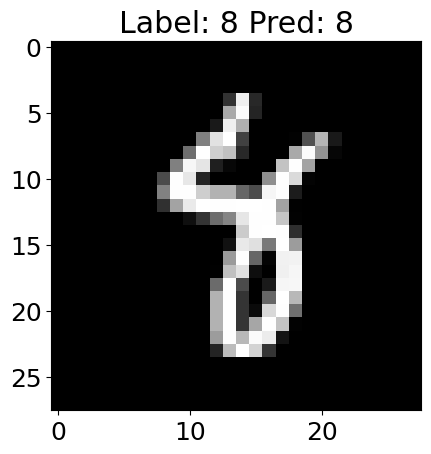

In [11]:
idx=800
plt.imshow(X_train[idx,:].reshape(nrows,ncols),cmap="gray")

prediction=np.argmax(cnn.predict(X_train[idx,:].reshape(-1,nrows,ncols),verbose=0), axis=-1)[0]
label=y_train[idx]
plt.title(f"Label: {label} Pred: {prediction}")

In [10]:
pred_labels=np.argmax(cnn.predict(X_train.reshape(-1,nrows,ncols),verbose=1),axis=-1)
errors=~(pred_labels==y_train)
errors_idx=np.where(errors)[0]
print(len(errors_idx))

9375/9375 [==============================] - 10s 1ms/step
20322


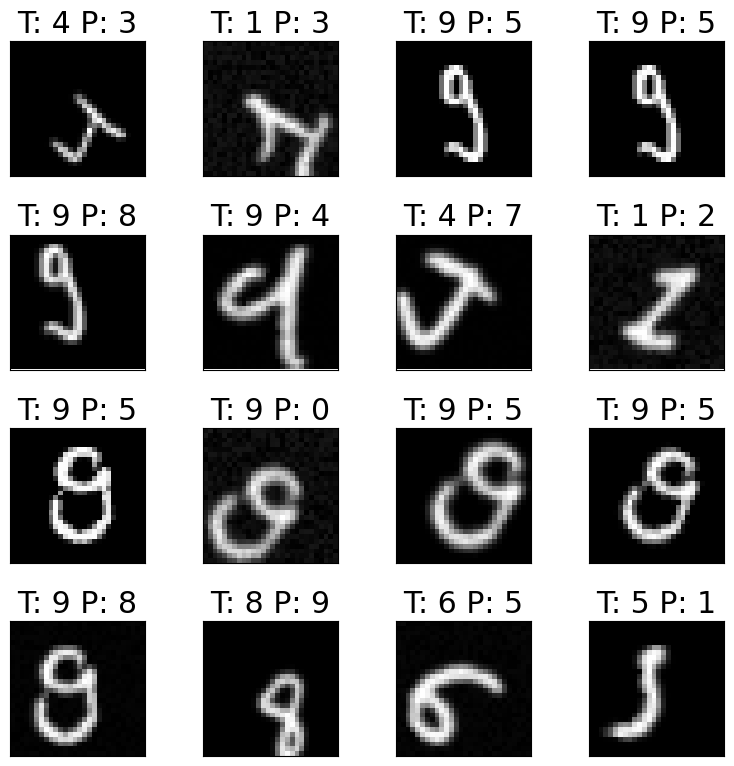

In [13]:
n=0

idxs=np.arange(n*16,(n+1)*16)

fig,axs=plt.subplots(4,4,squeeze=False,figsize=(8,8))
for ax,i in zip(axs.flatten(),idxs):
    idx=errors_idx[i]
    prediction=pred_labels[idx]
    true_label=y_train[idx]
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_title(f"T: {true_label} P: {prediction}")
    ax.imshow(X_train[idx,:].reshape(nrows,ncols),cmap="gray")
plt.tight_layout()

FC_64_128_i: 1630

FC_64_128: 654

mal_CNN_16_32_FC_64_128: 642

mal_CNN_16_32_FC_64_128_aug: 32264

CNN_16_32_FC_64_128_aug: 11035

CNN_16_32_FC_64_128: 233

CNN_16_32_FC_64_128_gpu: 171

CNN_16_32_FC_64_128_gpu_aug: 9053

CNN_16_32_64_FC_64_128_gpu_aug: 20322

CNN_16_32_64_FC_128_64_gpu_aug:

1/1 [==============================] - 0s 53ms/step


C:\Users\Ivan\AppData\Local\Temp\ipykernel_24916\3224783444.py:28: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()


IndexError: too many indices for array: array is 2-dimensional, but 4 were indexed

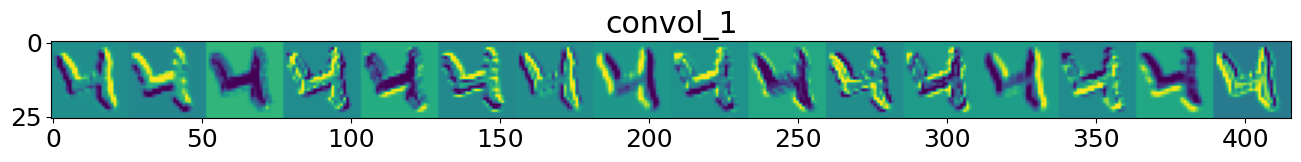

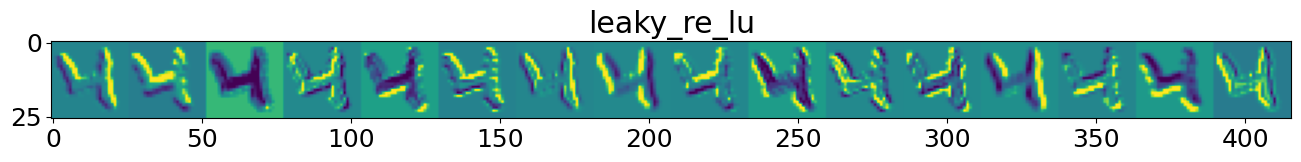

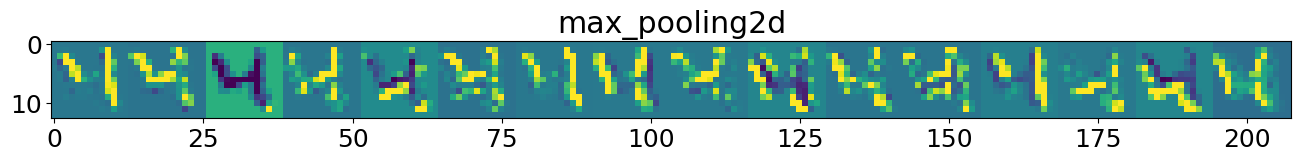

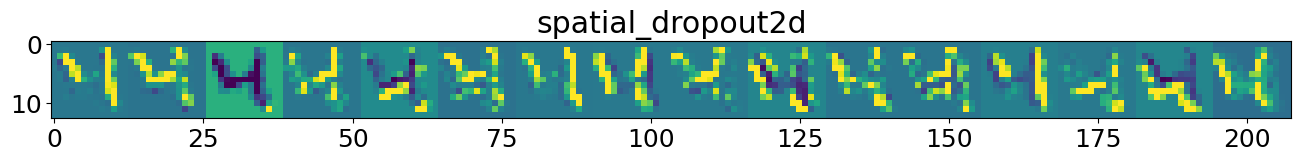

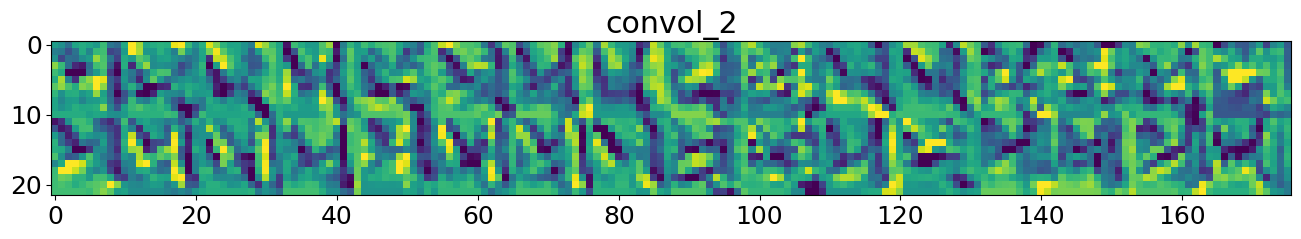

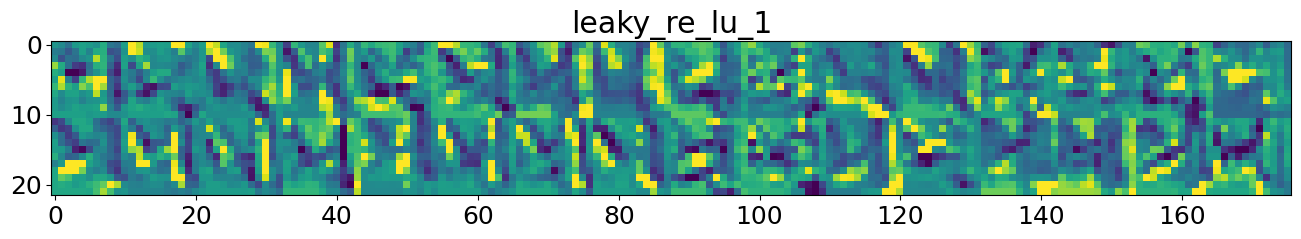

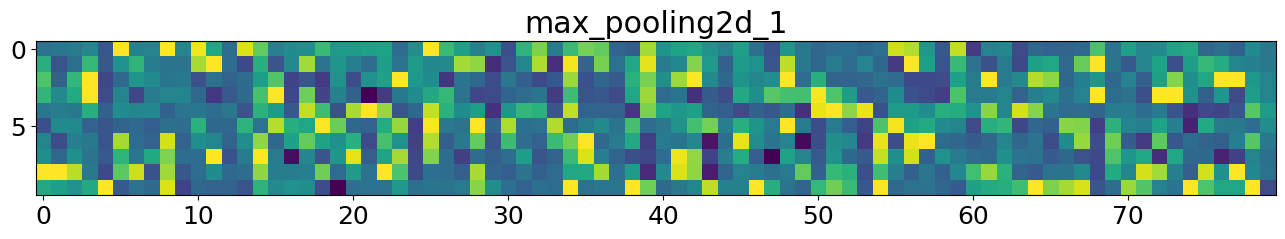

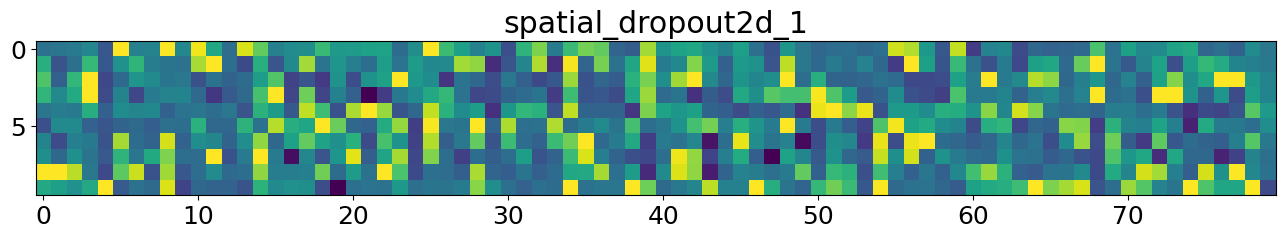

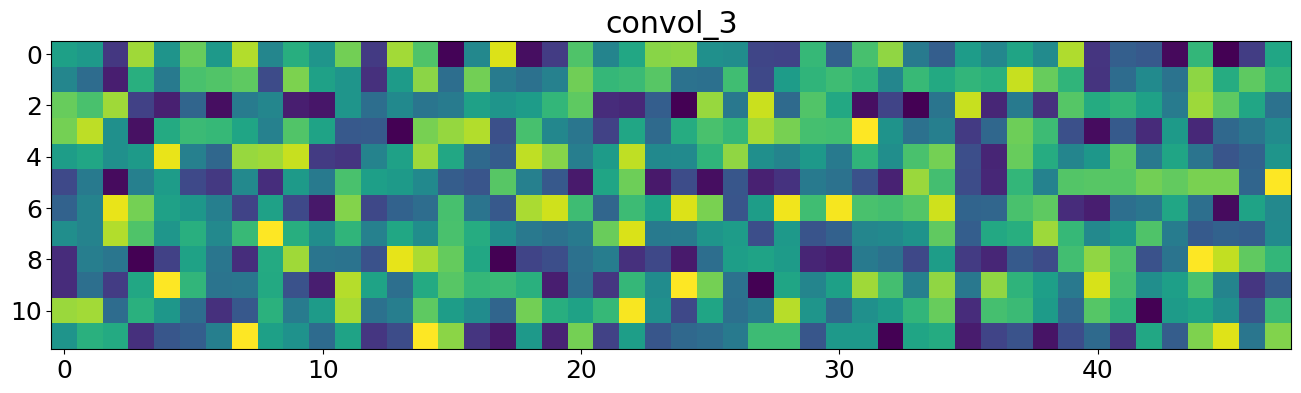

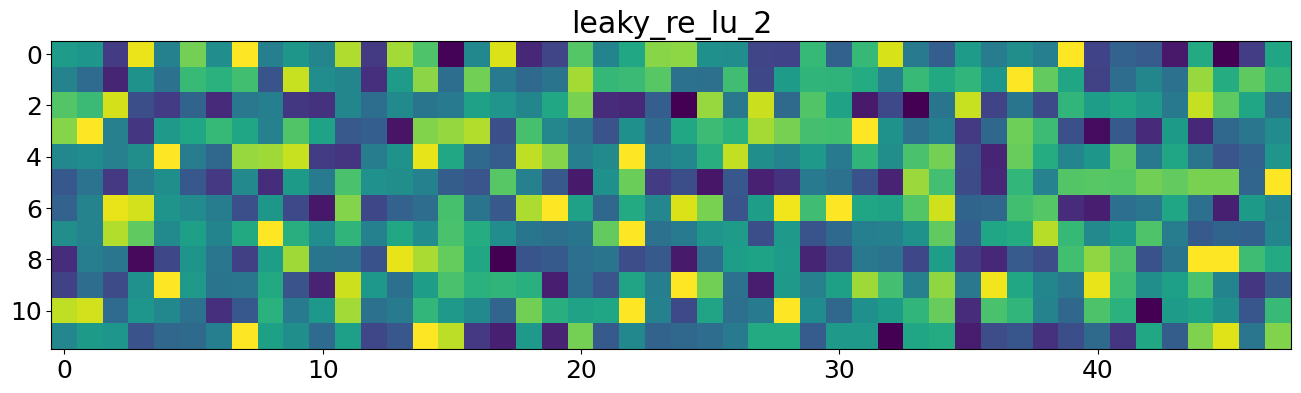

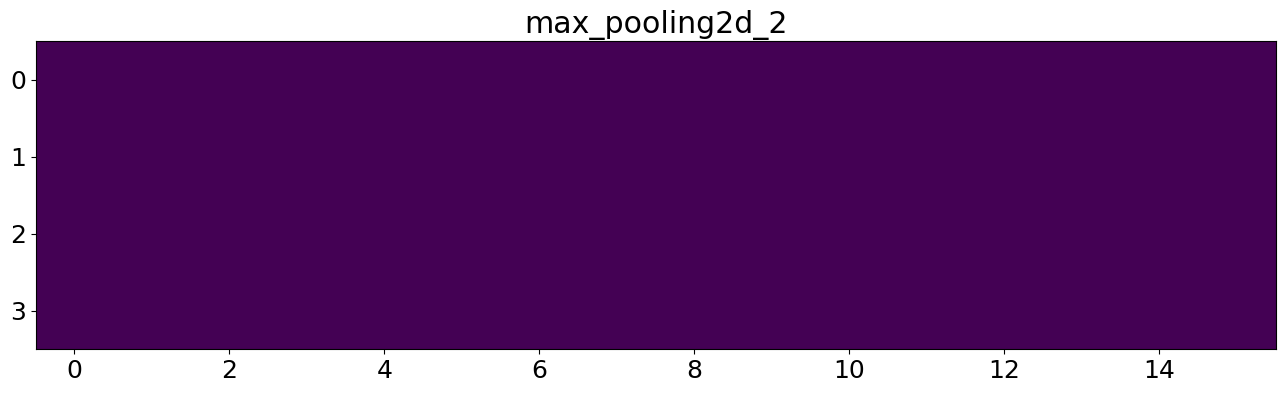

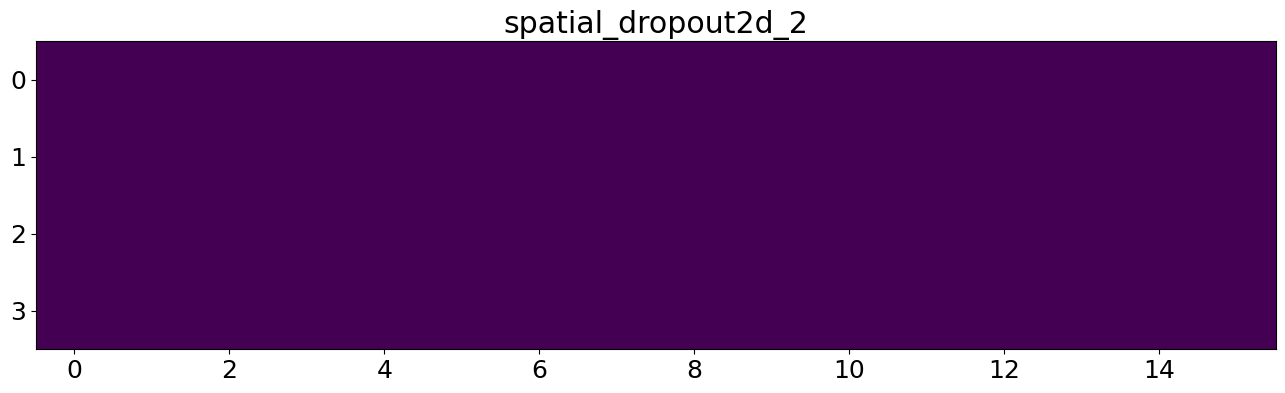

In [16]:
# https://towardsdatascience.com/visualizing-intermediate-activations-of-a-cnn-trained-on-the-mnist-dataset-2c34426416c8

img = X_train[100,:].reshape(nrows,ncols).reshape(1,28,28,1)

model=cnn

layer_outputs = [layer.output for layer in model.layers[1:-1]]
activation_model = Model(inputs=model.input,outputs=layer_outputs)

activations = activation_model.predict(img)

layer_names = []
for layer in model.layers[1:-1]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')